['Metadata I/O Time', 'Checksum Time', 'Communication Time', 'Data I/O Time']


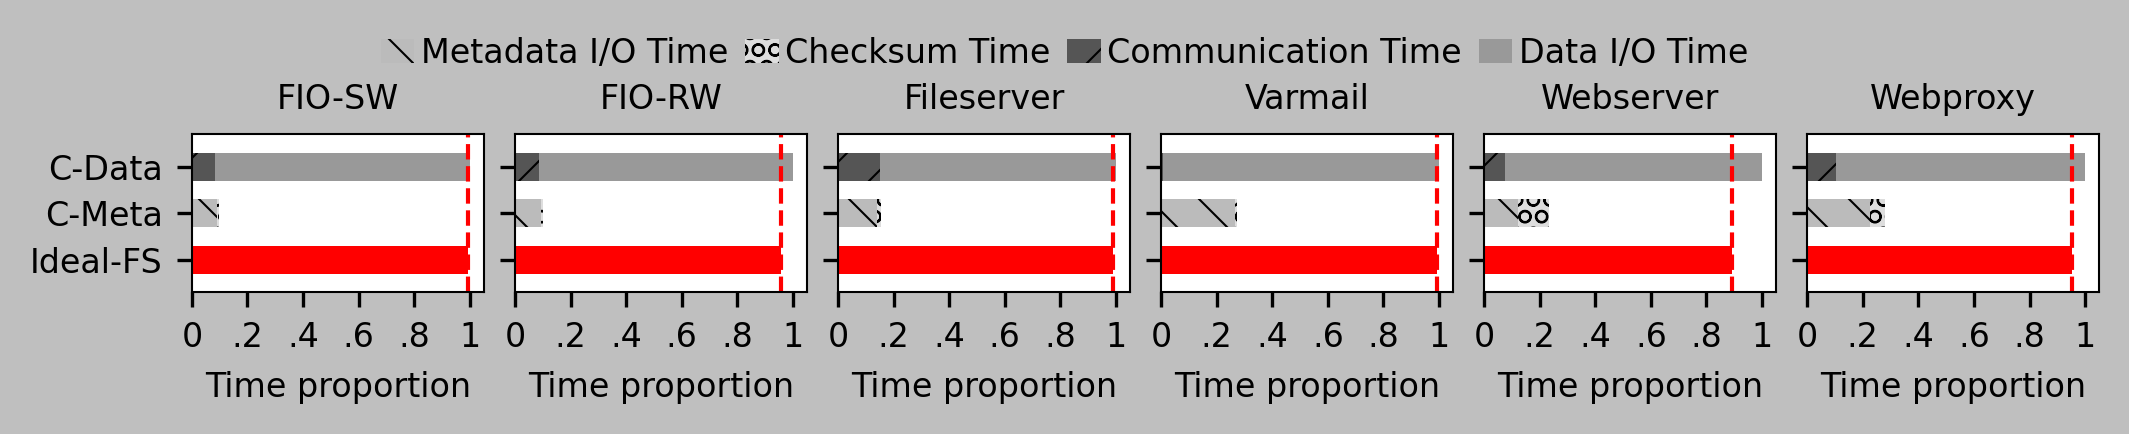

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Plotting Settings
fig = plt.figure(dpi=300, figsize=(cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(3)))
bar_width = 0.25
true_width = 0.15
inner_width = 0.1
num_job = 1


colors = ["#555555", "#999999", "#BBBBBB", "#DDDDDD"]
patterns = ['//', '', '\\\\', "OOO"]
legend_map = {
    'comu(ns)': 'Communication Time',
    'data(ns)': 'Data I/O Time',
    'meta(ns)': 'Metadata I/O Time',
    'data_csum(ns)': 'Checksum Time',
    'ideal': 'Ideal Data Time'
}

files = [
    "./performance-comparison-table-parfs",
    "./performance-comparison-table-idel",
]
fss = ["parfs", "idel"]
combine_file = "./performance-comparison-table-combine"

all_data = []
for file, fs in zip(files, fss):
    df = pd.read_csv(file, sep=r"\s+", engine='python')
    df.insert(0, "fs", fs)
    all_data.append(df)

merged_df = pd.concat(all_data, ignore_index=True)

# 拆分parfs为两个虚拟组
parfs_rows = merged_df[merged_df['fs'] == 'parfs'].copy()
# 第一个组：comu和data
group1 = parfs_rows.copy()
group1['fs'] = 'parfs_comu_data'
group1['total_time(ns)'] = group1['comu(ns)'] + group1['data(ns)']
group1['meta(ns)'] = 0
group1['data_csum(ns)'] = 0
# 第二个组：meta和data_csum
group2 = parfs_rows.copy()
group2['fs'] = 'parfs_meta_csum'
group2['total_time(ns)'] = group2['meta(ns)'] + group2['data_csum(ns)']
group2['comu(ns)'] = 0
group2['data(ns)'] = 0

merged_df = merged_df[merged_df['fs'] != 'parfs']
merged_df = pd.concat([merged_df, group1, group2], ignore_index=True)

merged_df.to_csv(combine_file, index=False)

files = [combine_file]

workloads = ["write", "randwrite", "fileserver.f", "varmail.f", "webserver.f", "webproxy.f"]
workloads_remap = ["FIO-SW", "FIO-RW", "Fileserver", "Varmail", "Webserver", "Webproxy"]

breakdown_times = ['comu(ns)', 'data(ns)', 'meta(ns)', 'data_csum(ns)']
bars = []
global_color_idx = 0
color_map = {}

for fid, file in enumerate(files):
    with open(file, "r") as f:
        df = pd.read_csv(f, sep=",", engine='python')
    
    sort_dict = {"idel": 0, "parfs_comu_data": 2, "parfs_meta_csum": 1}
    sort_df = pd.DataFrame(df['fs'].map(sort_dict))
    df = df.iloc[sort_df.sort_values(by=["fs"]).index]
    
    fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
    
    x = list(range(1, len(workloads) + 1))
    
    pivots = []
    workload_map = {w: [] for w in workloads}

    # 初始化颜色映射
    color_map = {
        'comu(ns)': colors[0],
        'data(ns)': colors[1],
        'meta(ns)': colors[2],
        'data_csum(ns)': colors[3]
    }

    for fs in fss:
        for workload in workloads:
            total_time = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0]
            workload_map[workload].append(total_time)


    for workload_id, workload in enumerate(workloads):
        pivots = []
        for fs_idx, fs in enumerate(fss):
            subfig = plt.subplot(1, 6, workload_id + 1)
            
            # 确定分组和样式
            if fs == 'parfs_comu_data':
                current_breakdown = breakdown_times[:2]
                group_patterns = [patterns[0], patterns[1]]
            elif fs == 'parfs_meta_csum':
                current_breakdown = breakdown_times[2:]
                group_patterns = [patterns[2], patterns[3]]
            elif fs == 'idel':
                current_breakdown = ['ideal']  # 特殊标记
            else:
                current_breakdown = breakdown_times
            
            pivot = x[workload_id] - (len(fss) * bar_width)/2 + bar_width/2 + fs_idx*bar_width
            pivots.append(pivot)
            
            left = 0
            for idx, time in enumerate(current_breakdown):
                # 处理理想情况
                if fs == "idel":
                    width = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0] / max(workload_map[workload])
                    color = 'red'
                    hatch = ''
                    label = 'ideal'
                else:
                    width = df[(df['workloads'] == workload) & (df['fs'] == fs)][time].iloc[0] / max(workload_map[workload])
                    color = color_map[time]
                    hatch = group_patterns[idx]
                    label = time
                
                # 绘制柱状图
                bar = subfig.barh(y=pivot, width=width, color=color, 
                                 left=left, hatch=hatch, linewidth=0.5,
                                 label=label, height=true_width)[0]
                left += width
                
                # 收集图例句柄（每个类型只收集一次）
                if (workload_id == 0) and (label != 'ideal') and (label not in [l for b,l in bars]):
                    bars.append((bar, label))

            # 绘制理想情况的参考线
            if fs == "idel":
                plt.vlines(x=width, ymin=pivot-true_width/2-0.1, 
                          ymax=pivot+true_width/2+0.6, 
                          color="red", linewidth=1, linestyle="--")

        # 坐标轴设置
        subfig.set_ylim(pivots[0]-true_width/2-0.1, pivots[-1]+true_width/2+0.1)
        subfig.tick_params(bottom=False, top=False, left=False, right=False)
        
        # Y轴标签（仅第一个子图）
        if workload_id == 0:
            yticklabels = []
            for fs in fss:
                if fs == 'parfs_comu_data': yticklabels.append("C-Data")
                elif fs == 'parfs_meta_csum': yticklabels.append("C-Meta")
                elif fs == 'idel': yticklabels.append("Ideal-FS")
                else: yticklabels.append(fs)
            subfig.set_yticks(pivots)
            subfig.set_yticklabels(yticklabels, fontsize=8)
        else:
            subfig.set_yticklabels([])

        # 其他设置保持不变
        subfig.set_title(f"{workloads_remap[workload_id]}", fontsize=8)
        subfig.set_xlim([0, 1.05])
        subfig.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        subfig.set_xticklabels(["0", ".2", ".4", ".6", ".8", "1"], fontsize=8)
        subfig.set_xlabel("Time proportion", fontsize=8)

        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        subfig.tick_params(bottom=True, top=False, left=True, right=False, which='major')

# 构建图例
unique_labels = []
handles = []
for bar, label in bars:
    if label not in unique_labels:
        unique_labels.append(legend_map[label])
        handles.append(bar)

print(unique_labels)

fig.legend(handles=handles, labels=unique_labels, 
           loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=8)
            
plt.tight_layout(pad=0.4)
plt.savefig("./FIG-PerfBreakDown-ChimeraFS.pdf", bbox_inches='tight', pad_inches=0)


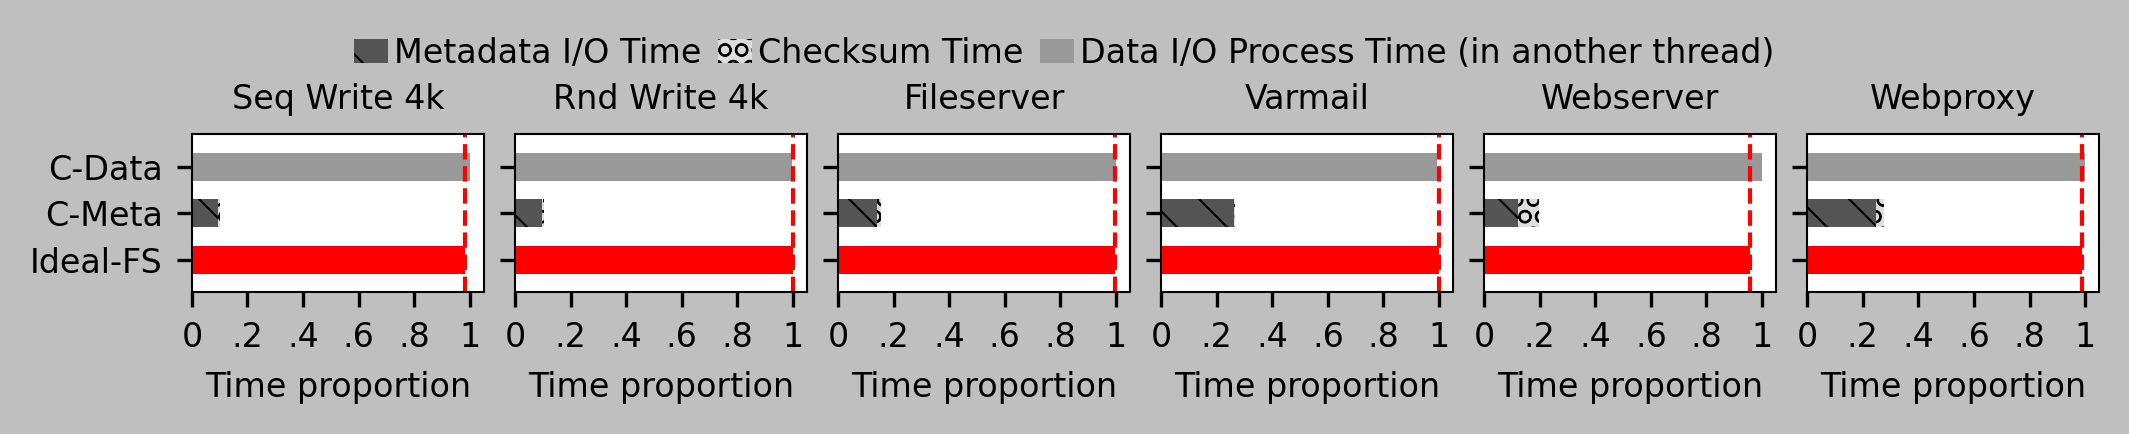

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value / 2.54

plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Plotting Settings
fig = plt.figure(dpi=300, figsize=(cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(3)))
bar_width = 0.25
true_width = 0.15
inner_width = 0.1
num_job = 1

colors = ["#555555", "#999999", "#BBBBBB", "#DDDDDD"]
patterns = ['//', '', '\\\\', "OOO"]
legend_map = {
    'comu(ns)': 'Data I/O Process Time (in another thread)',
    'data(ns)': 'Data I/O Time',
    'meta(ns)': 'Metadata I/O Time',
    'data_csum(ns)': 'Checksum Time',
    'ideal': 'Ideal Data Time',
    'parfs_comu_data_total': 'Data I/O Process Time (in another thread)'
}

files = [
    "./performance-comparison-table-parfs",
    "./performance-comparison-table-idel",
]
fss = ["parfs", "idel"]
combine_file = "./performance-comparison-table-combine"

all_data = []
for file, fs in zip(files, fss):
    df = pd.read_csv(file, sep=r"\s+", engine='python')
    df.insert(0, "fs", fs)
    all_data.append(df)

merged_df = pd.concat(all_data, ignore_index=True)

# 拆分parfs为两个虚拟组
parfs_rows = merged_df[merged_df['fs'] == 'parfs'].copy()
# 第一个组：comu和data
group1 = parfs_rows.copy()
group1['fs'] = 'parfs_comu_data'
group1['total_time(ns)'] = group1['comu(ns)'] + group1['data(ns)']
group1['meta(ns)'] = 0
group1['data_csum(ns)'] = 0
# 第二个组：meta和data_csum
group2 = parfs_rows.copy()
group2['fs'] = 'parfs_meta_csum'
group2['total_time(ns)'] = group2['meta(ns)'] + group2['data_csum(ns)']
group2['comu(ns)'] = 0
group2['data(ns)'] = 0

merged_df = merged_df[merged_df['fs'] != 'parfs']
merged_df = pd.concat([merged_df, group1, group2], ignore_index=True)

merged_df.to_csv(combine_file, index=False)

files = [combine_file]

workloads = ["write", "randwrite", "fileserver.f", "varmail.f", "webserver.f", "webproxy.f"]
workloads_remap = ["Seq Write 4k", "Rnd Write 4k", "Fileserver", "Varmail", "Webserver", "Webproxy"]

breakdown_times = [['comu(ns)'], ['data(ns)'], ['meta(ns)'], ['data_csum(ns)']]
bars = []
global_color_idx = 0
color_map = {}

for fid, file in enumerate(files):
    with open(file, "r") as f:
        df = pd.read_csv(f, sep=",", engine='python')

    sort_dict = {"idel": 0, "parfs_comu_data": 2, "parfs_meta_csum": 1}
    sort_df = pd.DataFrame(df['fs'].map(sort_dict))
    df = df.iloc[sort_df.sort_values(by=["fs"]).index]

    fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']

    x = list(range(1, len(workloads) + 1))

    workload_map = {w: [] for w in workloads}

    color_map = {
        'comu(ns)': colors[2],
        'data(ns)': colors[1],
        'meta(ns)': colors[0],
        'data_csum(ns)': colors[3]
    }

    for fs in fss:
        for workload in workloads:
            total_time = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0]
            workload_map[workload].append(total_time)

    for workload_id, workload in enumerate(workloads):
        subfig = plt.subplot(1, 6, workload_id + 1)

        pivots = []
        yticklabels = []

        for fs_idx, fs in enumerate(fss):
            pivot = x[workload_id] - (len(fss) * bar_width)/2 + bar_width/2 + fs_idx*bar_width

            if fs == 'parfs_comu_data':
                total = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0]
                width = total / max(workload_map[workload])
                bar = subfig.barh(y=pivot, width=width, color=colors[1],
                                  left=0, hatch='', linewidth=0.5,
                                  label='parfs_comu_data_total', height=true_width)[0]
                if (workload_id == 0):
                    bars.append((bar, 'parfs_comu_data_total'))
                pivots.append(pivot)
                yticklabels.append("C-Data")
                continue

            if fs == 'parfs_meta_csum':
                current_breakdown = breakdown_times[2:]
                group_patterns = [patterns[2], patterns[3]]
            elif fs == 'idel':
                current_breakdown = ['ideal']
            else:
                current_breakdown = breakdown_times

            left = 0
            for idx, time in enumerate(current_breakdown):
                if fs == "idel":
                    width = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0] / max(workload_map[workload])
                    color = 'red'
                    hatch = ''
                    label = 'ideal'
                else:
                    width = df[(df['workloads'] == workload) & (df['fs'] == fs)][time].iloc[0] / max(workload_map[workload])
                    color = color_map[time[0]]
                    hatch = group_patterns[idx]
                    label = time[0]

                bar = subfig.barh(y=pivot, width=width, color=color,
                                  left=left, hatch=hatch, linewidth=0.5,
                                  label=label, height=true_width)[0]
                left += width

                if (workload_id == 0) and (label != 'ideal') and (label not in [l for b, l in bars]):
                    bars.append((bar, label))

            if fs == "idel":
                plt.vlines(x=width, ymin=pivot - true_width/2 - 0.1,
                           ymax=pivot + true_width/2 + 0.6,
                           color="red", linewidth=1, linestyle="--")

            pivots.append(pivot)
            if fs == 'parfs_meta_csum':
                yticklabels.append("C-Meta")
            elif fs == 'idel':
                yticklabels.append("Ideal-FS")
            else:
                yticklabels.append(fs)

        subfig.set_ylim(pivots[0] - true_width/2 - 0.1, pivots[-1] + true_width/2 + 0.1)
        subfig.tick_params(bottom=False, top=False, left=False, right=False)

        if workload_id == 0:
            subfig.set_yticks(pivots)
            subfig.set_yticklabels(yticklabels, fontsize=8)
        else:
            subfig.set_yticks(pivots)
            subfig.set_yticklabels([])

        subfig.set_title(f"{workloads_remap[workload_id]}", fontsize=8)
        subfig.set_xlim([0, 1.05])
        subfig.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        subfig.set_xticklabels(["0", ".2", ".4", ".6", ".8", "1"], fontsize=8)
        subfig.set_xlabel("Time proportion", fontsize=8)

        ax = fig.gca()
        lw = 0.5
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(lw)
        subfig.tick_params(bottom=True, top=False, left=True, right=False, which='major')

# 构建图例
unique_labels = []
handles = []
for bar, label in bars:
    if label not in unique_labels:
        unique_labels.append(legend_map[label])
        handles.append(bar)

fig.legend(handles=handles, labels=unique_labels,
           loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), frameon=False,
           columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=8)

plt.tight_layout(pad=0.4)
plt.savefig("./FIG-PerfBreakDown-ChimeraFS.pdf", bbox_inches='tight', pad_inches=0)
